In [1]:
from alntk.alignment import import_from_fasta, get_unaligned_seqs, get_compact_alignment, write_to_fasta
from alntk.plotting import default_plot_style

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
color_cycle = default_plot_style()
data_folder = '../data/'

# Iterative approach to compactifying the alignment

In summary, the first approach I'm attempting to get a smaller alignment is to make it "compact". This is done by the elimination of sequences, and by deleting some sequences I'm hoping to get columns that are entirely gaps. If I delete the right sequences, I should be able to delete the entirely gapped columns and get a more compact alignment. However, this does not guarantee me that I will necessarily get less gaps: in fact, as soon as I delete the columns, the distribution might change. Let's see what happens.

In [4]:
new_aln_descs, new_aln_seqs = import_from_fasta(data_folder + 'new_aln.faa')
v, i, c = np.unique(new_aln_descs, return_index=True, return_counts=True)
unique_mask = np.where(c == 1)[0]
new_aln_seqs = new_aln_seqs[unique_mask]
new_aln_descs = new_aln_descs[unique_mask]
np.random.seed(42)
subsample_mask = np.random.randint(0, len(new_aln_descs), size=10_000)
subaln_seqs = new_aln_seqs[subsample_mask]
subaln_descs = new_aln_descs[subsample_mask]

In [5]:
subaln_seqs.shape

(10000, 823)

# Number of sequences/columns per iteration

Let's plot the dimension of the alignments per thresholds (say 0.8, 0.9, 0.99 and 0.999) by doing 20 iterations.

In [83]:
thresholds = [0.8, 0.9, 0.99, 0.999]
c_aln_shapes_thr = []
for threshold in thresholds:
    c_aln_shapes = []
    sad0, sas0 = subaln_descs, subaln_seqs
    for i in range(20):
        c_aln_shapes.append(sas0.shape)
        sadf, sasf = get_compact_alignment(sad0, sas0, threshold)
        sad0, sas0 = sadf, sasf
    c_aln_shapes.append(sas0.shape)
    c_aln_shapes = np.array(c_aln_shapes)
    c_aln_shapes_thr.append(c_aln_shapes)
c_aln_shapes_thr = np.array(c_aln_shapes_thr)

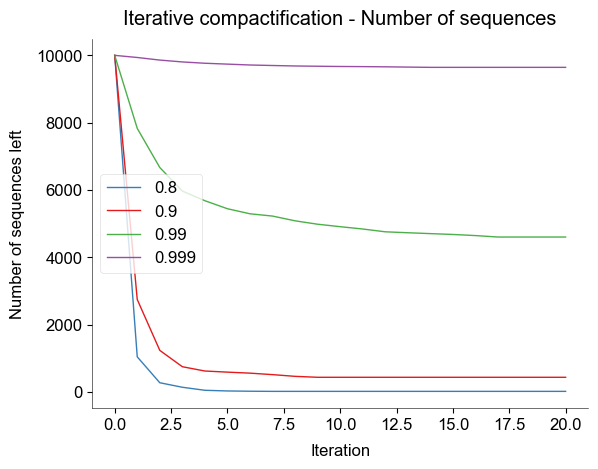

In [137]:
fig, ax = plt.subplots()
plt.title('Iterative compactification - Number of sequences')
for thr_idx, threshold in enumerate(thresholds):
    ax.plot(c_aln_shapes_thr[thr_idx, :, 0], color='#'+color_cycle[thr_idx], label=str(threshold))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Number of sequences left')
plt.show()

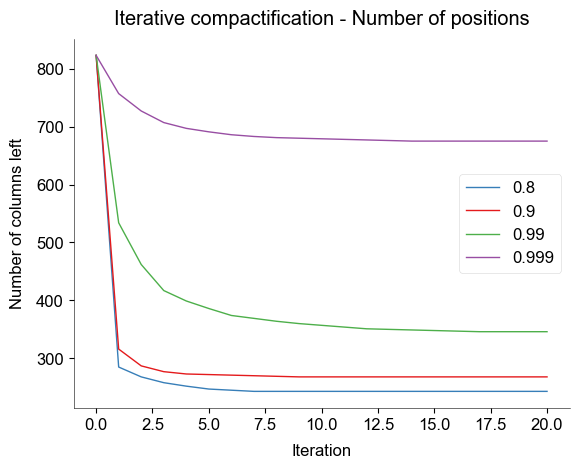

In [138]:
fig, ax = plt.subplots()
plt.title('Iterative compactification - Number of positions')
for thr_idx, threshold in enumerate(thresholds):
    ax.plot(c_aln_shapes_thr[thr_idx, :, 1], color='#'+color_cycle[thr_idx], label=str(threshold))
plt.xlabel('Iteration')
plt.ylabel('Number of columns left')
plt.legend()
plt.show()

# Distribution of gaps in columns per iteration for different thresholds

We can plot the distribution of the ratio of gaps per column as a histogram. Our goal is to see whether, as we iterate through the compactification steps, we get a convergence to a distribution of values and whether it has a peak at highly gapped columns.

We see that we get reasonably low amount of gapped columns for thresholds 0.9 and 0.95, while at 0.99 the iterations converge to a distribution with a peak on highly gapped columns.

{'P32821', 'Q9P0G3', 'O35164', 'Q91X79', 'P24664', 'P51779', 'Q28153', 'P03953', 'P11034', 'P03951', 'P08218', 'Q92876', 'P51124', 'P35030', 'Q8VHK8', 'Q61096', 'Q9Y5K2', 'P00767', 'Q3T0A3', 'P19799', 'Q9PSN3', 'P00773', 'Q29461', 'P04187', 'P00764', 'P17977', 'Q804X6', 'A8QL53', 'P23946', 'P07478', 'Q867B0', 'P21844', 'P32038', 'P20718', 'P12788', 'P07477', 'P35033', 'P08217', 'A7WPL7', 'P07146', 'Q29463', 'P29786', 'Q3UQ41', 'P21842', 'Q9DG84', 'P08426', 'P49862', 'P00763', 'P15119', 'P06871', 'P11033', 'P52195', 'A8QL57', 'P05208', 'Q9UNI1', 'Q06606', 'P06872', 'P97594', 'P35049', 'Q63ZK0', 'P50340', 'Q1JRP2', 'P16049', 'Q07943', 'Q5QSK2', 'Q9JIQ8', 'Q90627', 'P14417', 'P00760', 'Q3SYP2', 'Q5MCS0', 'P00770', 'P70059', 'Q7M3E1', 'P08884', 'Q8CGR5', 'P98073', 'P50339', 'O46644', 'Q8VHJ4', 'Q7SIG2', 'Q91041', 'P18291', 'Q99895', 'P10144', 'P05805', 'Q90629', 'Q00356', 'P00746', 'P21812', 'Q91509', 'Q91VE3', 'P00774', 'P35032', 'P08419', 'P16292', 'P55091', 'Q7Z410', 'Q7SIG3', 'P00766',

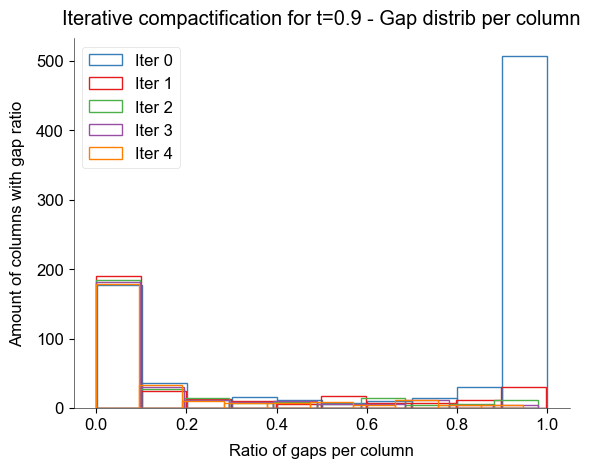

In [174]:
threshold = 0.9
c_aln_shapes = []
sad0, sas0 = subaln_descs, subaln_seqs
plt.title(f'Iterative compactification for t={threshold} - Gap distrib per column')
for i in range(4):
    c_aln_shapes.append(sas0.shape)
    current_sp = set([d.split('|')[1] for d in sadf if d.split('|')[0]=='sp'])
    if i>0: print(prev_sp - current_sp)
    plt.hist(np.sum(sas0 == '-', axis=0) / sas0.shape[0], label='Iter '+str(i), facecolor='none', edgecolor='#'+color_cycle[i], linewidth=1)
    sadf, sasf = get_compact_alignment(sad0, sas0, threshold)
    sad0, sas0 = sadf, sasf
    prev_sp = current_sp
print([d.split('|')[1] for d in sadf if d.split('|')[0]=='sp'])
plt.hist(np.sum(sas0 == '-', axis=0) / sas0.shape[0], label='Iter '+str(i+1), facecolor='none', edgecolor='#'+color_cycle[i+1], linewidth=1)
c_aln_shapes.append(sas0.shape)
c_aln_shapes = np.array(c_aln_shapes)
plt.xlabel('Ratio of gaps per column')
plt.ylabel('Amount of columns with gap ratio')
plt.legend()
plt.show()

set()
{'P54629', 'Q71QJ1', 'Q7Z269', 'P98139', 'Q7Z410', 'Q3UKY7'}
{'Q9BYE2', 'Q6IE06'}
['Q9PTL3', 'P35004', 'B0FXM1', 'P13366', 'Q9UKR0', 'Q14C59', 'Q71QI0', 'P00772', 'Q9QUK9', 'P47797', 'Q9PT51', 'Q9DF66', 'P00762', 'O13060', 'P35031']


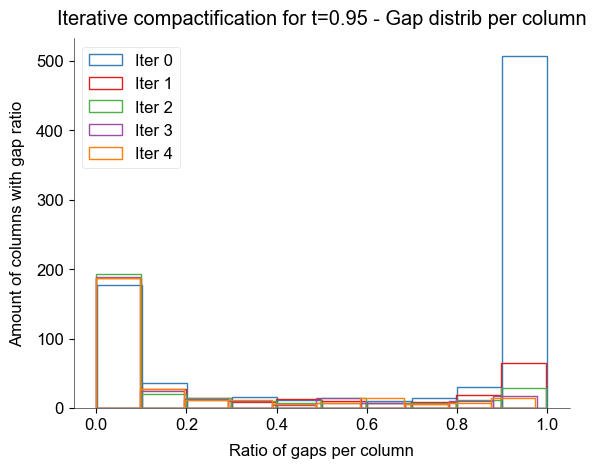

In [175]:
threshold = 0.95
c_aln_shapes = []
sad0, sas0 = subaln_descs, subaln_seqs
plt.title(f'Iterative compactification for t={threshold} - Gap distrib per column')
for i in range(4):
    c_aln_shapes.append(sas0.shape)
    current_sp = set([d.split('|')[1] for d in sadf if d.split('|')[0]=='sp'])
    if i>0: print(prev_sp - current_sp)
    plt.hist(np.sum(sas0 == '-', axis=0) / sas0.shape[0], label='Iter '+str(i), facecolor='none', edgecolor='#'+color_cycle[i], linewidth=1)
    sadf, sasf = get_compact_alignment(sad0, sas0, threshold)
    sad0, sas0 = sadf, sasf
    prev_sp = current_sp
print([d.split('|')[1] for d in sadf if d.split('|')[0]=='sp'])
plt.hist(np.sum(sas0 == '-', axis=0) / sas0.shape[0], label='Iter '+str(i+1), facecolor='none', edgecolor='#'+color_cycle[i+1], linewidth=1)
c_aln_shapes.append(sas0.shape)
c_aln_shapes = np.array(c_aln_shapes)
plt.xlabel('Ratio of gaps per column')
plt.ylabel('Amount of columns with gap ratio')
plt.legend()
plt.show()

set()
{'P15945', 'P33619', 'P32824'}
{'P56677', 'Q8I6K0', 'Q5M8S2'}
['Q7Z269', 'Q9PTL3', 'P35004', 'D8MIA0', 'B0FXM1', 'Q3UKY7', 'P13366', 'Q2QA04', 'Q71QI5', 'Q9UKR0', 'Q6GPI1', 'Q14C59', 'Q91053', 'P20231', 'Q71QI0', 'Q8JH85', 'Q66TN7', 'P54629', 'P00772', 'Q9QUK9', 'Q71QJ1', 'Q66TN7', 'Q6IE06', 'P47797', 'Q9BYE2', 'Q9GZN4', 'P35038', 'P50343', 'Q66TN7', 'Q9PT51', 'Q802F0', 'P98139', 'Q9DF66', 'P33587', 'P00762', 'O13060', 'P35031', 'Q7Z410']


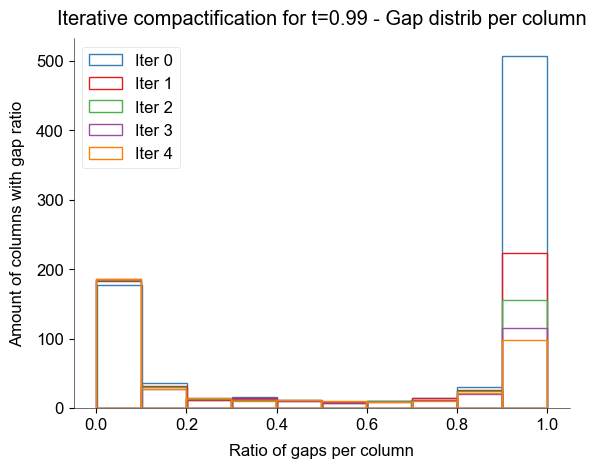

In [176]:
threshold = 0.99
c_aln_shapes = []
sad0, sas0 = subaln_descs, subaln_seqs
plt.title(f'Iterative compactification for t={threshold} - Gap distrib per column')
for i in range(4):
    c_aln_shapes.append(sas0.shape)
    current_sp = set([d.split('|')[1] for d in sadf if d.split('|')[0]=='sp'])
    if i>0: print(prev_sp - current_sp)
    plt.hist(np.sum(sas0 == '-', axis=0) / sas0.shape[0], label='Iter '+str(i), facecolor='none', edgecolor='#'+color_cycle[i], linewidth=1)
    sadf, sasf = get_compact_alignment(sad0, sas0, threshold)
    sad0, sas0 = sadf, sasf
    prev_sp = current_sp
print([d.split('|')[1] for d in sadf if d.split('|')[0]=='sp'])
plt.hist(np.sum(sas0 == '-', axis=0) / sas0.shape[0], label='Iter '+str(i+1), facecolor='none', edgecolor='#'+color_cycle[i+1], linewidth=1)
c_aln_shapes.append(sas0.shape)
c_aln_shapes = np.array(c_aln_shapes)
plt.xlabel('Ratio of gaps per column')
plt.ylabel('Amount of columns with gap ratio')
plt.legend()
plt.show()

# Test SP on entire alignment

0.95 seems to be a reasonable choice for the threshold of compactification. Let's see at five iterations of compactification which are the SwissProt sequences that we are throwing away. We are interested in skimming through the compactified sequences on the entire 

The last line is the remaining SwissProt entries. We can see that `CELA1_PIG`, `CTRA_BOVIN` and `TRY2_RAT` are still in the last alignment.

In [5]:
import requests
import time

In [6]:
def upkbid_to_names(upkbid_list):
    data={'ids': '"' + ','.join(upkbid_list) + '"', 'from': 'UniProtKB_AC-ID', 'to': 'UniProtKB', 'columns': 'protein_name', 'size': len(upkbid_list)+1}
    response = requests.post('https://rest.uniprot.org/idmapping/run', data=data)
    jobid = response.json()['jobId']
    # poll = 0
    print('Waiting for response from UniProt for the following IDs...')
    time.sleep(5)
    response_poll = requests.get('https://rest.uniprot.org/idmapping/status/'+jobid)
    # while not poll:
    #     try:
    #         response_poll = requests.get('https://rest.uniprot.org/idmapping/status/'+jobid)
    #         poll = 1
    #     except:
    #         time.sleep(5)
    #         poll = 0
    names = [e['to']['proteinDescription']['recommendedName']['fullName']['value'] for e in response_poll.json()['results']]
    ids = [e['to']['uniProtkbId'] for e in response_poll.json()['results']]
    return dict(zip(ids, names))

In [7]:
new_aln_seqs.shape

(113990, 823)

In [10]:
threshold = 0.95
sad0, sas0 = new_aln_descs, new_aln_seqs
for i in range(6):
    current_sp = set([d.split('|')[1] for d in sad0 if d.split('|')[0]=='sp'])
    if i>0:
        diff_sp = prev_sp - current_sp
        print(','.join(diff_sp))
    #     diff_sp_names = upkbid_to_names(diff_sp)
    #     print(diff_sp_names)
    sadf, sasf = get_compact_alignment(sad0, sas0, threshold)
    sad0, sas0 = sadf, sasf
    prev_sp = current_sp
    print('Iteration', i)
print(','.join([d.split('|')[1] for d in sadf if d.split('|')[0]=='sp']))
#print(','.join([d.split('|')[2] for d in sadf if d.split('|')[0]=='sp']))

Iteration 0
P08519,P43685,Q80WM7,Q76B45,Q9VCJ8,Q5R8J0,Q920S2,Q6DIV5,P09582,Q6H321,Q3UP87,Q9NZP8,O01887,Q61754,Q9VB68,Q924N9,Q6UWB4,P49864,Q8BJR6,B8VIV4,P0CW18,A0A6J1W8N1,P11032,Q5R5F6,Q7YRZ7,Q8BHM9,P20231,O97507,F2YMG0,C1JE15,P15948,P00755,Q56VR3,P29293,O88947,B5G6G5,Q9ESD1,P15947,P81428,Q9QYZ9,P00756,Q66TN7,A1L453,Q4TTV7,Q0VCX1,P98119,Q7RTZ1,P15949,Q61129,Q8CFG9,Q58L94,Q5G265,P57727,Q16651,Q9UBX7,P19006,P19637,P21902,Q5E9P5,P69526,Q9UKQ9,A0A1S4H5S2,Q8K4I7,B6D985,Q8BZ10,O35205,Q9D9M0,Q8BLH5,P10323,Q5K2P9,P27435,Q32KU2,Q26422,P16295,P84033,P13582,P83370,P36374,P00758,Q8CG14,P12323,Q6AY28,Q5FBW2,Q14BX2,P48740,P15950,O60259,B5U2W0,O35086,Q867B7,Q8MUG0,Q07276,Q9UKR3,P42280,Q14520,P20151,O97366,Q4R7Y7,Q9VP95,P15156,P36376,Q9GZN4,A0A182C2Z2,P23604,G3V801,P15120,A8JUP7,P06867,P07628,P19236,B6E141,Q1L658,Q28773,P36373,Q91WP0,P15946,Q5K4E3,Q27083,Q7RTY3,P81286,Q80YC5,Q7M761,P69525,P83748,Q7RTY7,P07647,Q9JJS8,O62589,P26324,Q8I6K0,O88780,Q9ES87,O43240,Q14B25,Q02844,A2VE36,Q9JHJ7,Q32LI2,Q80YN4,P49

The dimensions of the alignment are:

In [163]:
sasf.shape

(15421, 287)

Example sequences from the alignment are:

In [162]:
[''.join(s) for s in sasf[:10, :]]

['---IFVSVLFASCWGASLIPRRPRHDGRIVGGEPTDITNYPYQVSFEFF----GSHHCGAAIISELWVVTAGHCVDGIP--VSTVTFRAGTNVM----EEGGTVHEAAEIIAHPNFDY--LSLDCDIAVSKVTTAFTYQPSVQPVS-LAS----ADPPAG-AMAVVTGWG-STSSGG-----ALSPLLLKVSVPVVSFDACNASYSKYGGITSNMMCAGADEGGKDSCQGDSGGPLVVE-----KELVGIVSWGA--GCGVRGYPGVYASVAVLREFVTSNTD----',
 '-----------QLRSKASLILSGDIKERIVGGYAPVPHSIKYIVSIQTL---ERKHFCGGFLINKHWVVTAAHYY--------SLSIYEG----------TEQEILPHILVPHPSYNK--ITNNCDIMLIKLRAPFYLNSYVSIT-LLPRQG--APIAEG-RLCRVSGWGY-TNP--SG--GPIPSTLRTVMLPIVSTEKCNSSESFSGNITENMLCAGYSLGGKDACQGDSGGPLVCD-----GRVYGVVSWGK--GCADAQFPGVYTAVSKFRRWIDNTIFKNN-',
 '---------------------------------------------LQTR---SGSHFCGGSLINENWVVTAAHCEFN----PYSHIVVLGEYDRS-SNAESVQVKTVSRAITNPSWNP--YTLNNDITLLKLSSPAQLGPRVAPVC-LPPTN--LALPTN-LQCVTTGWGRTN----TNS-QALAVRLQQVTLPLIALNQCKQYWG--NQITSSMLCAGGVGA--SSCQGDSGGPLVYQNG-NVWTLIGIVSWGNS-NCNVR-TPAIYTRVSQFRNWIDYVVS----',
 '-----LWLLGVAGTLLQTAWAKPTISPGITGGNEAPVGKFLSTVGLRAD--ETGTNLCGGILIAPKYVLTAAHCCNGA-----IKVASIGSHFLN--GAQDGERIAVVRETRHPKFNP--GT

The gaps are distributed in the following way:

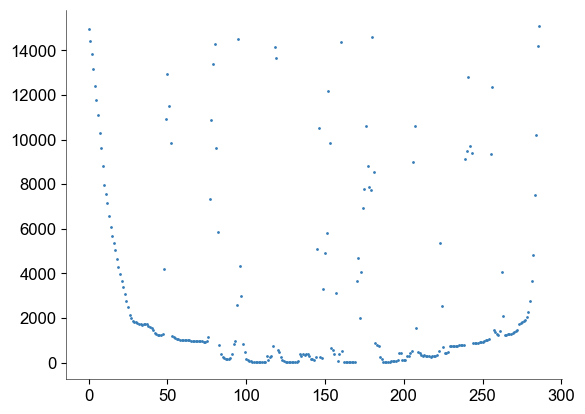

In [173]:
plt.plot(np.sum(sasf == '-', axis=0), '.', ms=2)